In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.regressor import generate_regressor_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["regressor"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['regressor']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-04 23:38:27.718528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 23:38:27.779891: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 23:38:28.194894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_067


In [2]:
sub = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,key_step,event,score,step,minutes
0,038441c925bb,5051.5,onset,0.834676,5039,1857.5
1,038441c925bb,10907.5,wakeup,0.754868,10895,2337.5
2,038441c925bb,20387.5,onset,0.630360,20375,2937.5
3,038441c925bb,27467.5,wakeup,0.880441,27455,2337.5
4,038441c925bb,40019.5,onset,0.879920,40007,297.5


,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,series_id,key_step,event,score,step,minutes,level
0,038441c925bb,4331.5,onset,0.834676,4319,1857.5,5
1,038441c925bb,4691.5,onset,0.834676,4679,1857.5,3
2,038441c925bb,4931.5,onset,0.834676,4919,1857.5,1
3,038441c925bb,5051.5,onset,0.834676,5039,1857.5,0
4,038441c925bb,5171.5,onset,0.834676,5159,1857.5,2


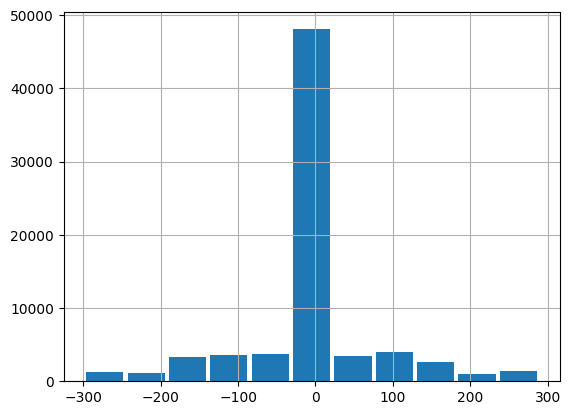

series_id     5331163
step          5331163
oof_stage2    5331163
minutes        877617
target          73351
sub_step        73351
key_step        73351
event           73351
score           73294
level           73351
dtype: int64
86.98822500205213


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score,level
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 300:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "key_step", "event", "score", "level"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [5]:
# 特徴生成
train, features = generate_regressor_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:21<00:00,  1.37it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4319.0,4331.5,onset,0.834676,5.0,...,0.0,0.960272,-0.002529,0.737917,0.0,0.998246,-0.000057,0.927509,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,0.0,4679.0,4691.5,onset,0.834676,3.0,...,0.0,0.959926,-0.003268,0.719422,0.0,0.998064,-0.000062,0.921510,0.0,2
2,038441c925bb,4931.5,0.978979,1257.5,73.0,4919.0,4931.5,onset,0.834676,1.0,...,0.0,0.956779,-0.003403,0.711094,0.0,0.997368,-0.000110,0.908672,0.0,2
3,038441c925bb,5051.5,0.120360,1857.5,-47.0,5039.0,5051.5,onset,0.834676,0.0,...,0.0,0.955621,-0.004250,0.706929,0.0,0.996829,-0.000130,0.899326,0.0,2
4,038441c925bb,5171.5,0.151996,2457.5,-167.0,5159.0,5171.5,onset,0.834676,2.0,...,0.0,0.955607,-0.003614,0.704544,0.0,0.995787,-0.000106,0.888587,0.0,2


(73351, 1387)

In [6]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["regressor"]["xgboost"], 
    es_rounds=100,
)
train["oof_regressor"] = trn_oof
train["key_step"] = train["step"]
train["sub_step_before_modify"] = train["sub_step"]
train["step"] = (train["sub_step"] + train["oof_regressor"]).astype(int)
sub = train[[
    "step", "sub_step_before_modify", "key_step", 
    "series_id", "score", "event", 
    "oof_stage2", "oof_regressor", 
    "target", "minutes", "level"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:84.66663
[100]	eval-rmse:63.59896
[200]	eval-rmse:59.54702
[300]	eval-rmse:58.75668
[400]	eval-rmse:58.55796
[500]	eval-rmse:58.52148
[600]	eval-rmse:58.50197
[700]	eval-rmse:58.49288
[800]	eval-rmse:58.50088
[900]	eval-rmse:58.49013
[1000]	eval-rmse:58.48881
[1074]	eval-rmse:58.48968


 20%|██        | 1/5 [00:20<01:21, 20.36s/it]

== fold 1 ==
[0]	eval-rmse:87.52082
[100]	eval-rmse:66.92637
[200]	eval-rmse:62.76992
[300]	eval-rmse:61.86336
[400]	eval-rmse:61.63474
[500]	eval-rmse:61.53954
[600]	eval-rmse:61.49775
[700]	eval-rmse:61.48990
[800]	eval-rmse:61.49085
[826]	eval-rmse:61.48424


 40%|████      | 2/5 [00:36<00:53, 17.78s/it]

== fold 2 ==
[0]	eval-rmse:88.14649
[100]	eval-rmse:68.96631
[200]	eval-rmse:65.43317
[300]	eval-rmse:64.67352
[400]	eval-rmse:64.47671
[500]	eval-rmse:64.42936
[600]	eval-rmse:64.39263
[700]	eval-rmse:64.38661
[726]	eval-rmse:64.38267


 60%|██████    | 3/5 [00:50<00:31, 15.92s/it]

== fold 3 ==
[0]	eval-rmse:87.04803
[100]	eval-rmse:66.76138
[200]	eval-rmse:62.93099
[300]	eval-rmse:62.19300
[400]	eval-rmse:62.01391
[500]	eval-rmse:61.96640
[600]	eval-rmse:61.92440
[700]	eval-rmse:61.92079
[800]	eval-rmse:61.91356
[860]	eval-rmse:61.91775


 80%|████████  | 4/5 [01:07<00:16, 16.44s/it]

== fold 4 ==
[0]	eval-rmse:85.81044
[100]	eval-rmse:65.71026
[200]	eval-rmse:62.18849
[300]	eval-rmse:61.62774
[400]	eval-rmse:61.49829
[500]	eval-rmse:61.45037
[600]	eval-rmse:61.42868
[700]	eval-rmse:61.41692
[800]	eval-rmse:61.40728
[900]	eval-rmse:61.41974
[922]	eval-rmse:61.41806


100%|██████████| 5/5 [01:24<00:00, 16.89s/it]


In [7]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.1732


event   tolerance
onset   12           0.059917
        36           0.123987
        60           0.153220
        90           0.170243
        120          0.181602
        150          0.187931
        180          0.191909
        240          0.193424
        300          0.194791
        360          0.196256
wakeup  12           0.074890
        36           0.136608
        60           0.166051
        90           0.185455
        120          0.197465
        150          0.205553
        180          0.209212
        240          0.210435
        300          0.211913
        360          0.213113
dtype: float64